# Model

In [1]:
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()

import torchvision

import torchvision.transforms as transforms

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import torch.optim as optim

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Common Funcs

In [3]:
## Loading images
def load_rgb(path):
    img = cv.imread(path)
    img = img[..., ::-1]
    return img

def load_gray(path):
    img = cv.imread(path, 0)
    
    return img

In [4]:
def rescale(img):
    e = 1e-4
    return (img - np.min(img)) / (np.max(img) - np.min(img) + e)

In [5]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    img = rescale(img)
    plt.imshow(img)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:
        plt.imsave(f'../data/outs/{title}.png', img)
        
    plt.show()
    plt.close(fig)


def plot_grayscale(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    img = rescale(img)
    plt.imshow(img, cmap='gray')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../imgs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)

## ConvNet

In [6]:
from torchvision.models import vgg11, VGG11_Weights

In [7]:
model = vgg11()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [8]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [9]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1000, batch_size=1, pre_train=False):
        super().__init__()
        
        self.flag = True
        
        # self.vgg_name=vgg_name
        self.pre_train = pre_train
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.switches = []
        self.org_shapes = []
        self.unpool_shapes = []
        self.feature_maps = []
        
        self.conv = nn.ModuleList()
        self.pool = nn.ModuleList()
        self.norm = nn.ModuleList()
        
        self.linear = nn.ModuleList()
        self.drop = nn.ModuleList()
        
        # =======================================================
        
        # layers = cfg[vgg_name]
        layers = cfg['VGG11']
        
        curr_channels = self.in_channels
        for i in range(len(layers)):
            if layers[i] == 'M':
                continue
            
            self.conv.append(nn.Conv2d(in_channels=curr_channels, out_channels=layers[i], kernel_size=3, stride=1, padding=1))
            
            if i+1 < len(layers) and layers[i+1] == 'M':
                self.pool.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True))
            else:
                self.pool.append(nn.Identity())
            
            # self.norm.append(nn.BatchNorm2d(num_features=layers[i]))
            self.norm.append(nn.Identity())
            curr_channels = layers[i]
        
        
        ## Average Pool
        # self.pool.append(nn.AvgPool2d(kernel_size=7))
        # self.pool.append(nn.AvgPool2d(kernel_size=7, stride=1))
        self.pool.append(nn.AdaptiveAvgPool2d(output_size=(7, 7)))
        
        ## Linear 1
        # self.linear.append(nn.Linear(in_features=512, out_features=4096))
        self.linear.append(nn.Linear(in_features=25088, out_features=4096))
        self.drop.append(nn.Dropout(p=0.5))
        
        ## Linear 2
        self.linear.append(nn.Linear(in_features=4096, out_features=4096))
        self.drop.append(nn.Dropout(p=0.5))
        
        ## Linear 3: Output
        self.linear.append(nn.Linear(in_features=4096, out_features=self.out_channels))
        self.drop.append(nn.Identity())
 
        # =======================================================

        ## Initialize weights
        if pre_train:
            self._init_weights_1()
        else:
            self._init_weights_2()
            
    
    def _init_weights_1(self):
        
        # pre_model = vgg11()
        # pre_model = vgg11(weights = 'DEFAULT')
        pre_model = vgg11(weights = VGG11_Weights.IMAGENET1K_V1)
        
        ## Conv Layers
        for i in range(len(self.conv)):
            with torch.no_grad():
                if i < 2:
                    self.conv[i].weight.copy_(pre_model.features[i * 3].weight)
                    
                    if pre_model.features[i * 3].bias is not None:
                        self.conv[i].bias.copy_(pre_model.features[i * 3].bias)
                else:
                    self.conv[i].weight.copy_(pre_model.features[(i + 4) + (i - 2) + ((i - 2) // 2)].weight)
                    
                    if pre_model.features[(i + 4) + (i - 2) + ((i - 2) // 2)].bias is not None:
                        self.conv[i].bias.copy_(pre_model.features[(i + 4) + (i - 2) + ((i - 2) // 2)].bias)
        
        ## Linear Layers            
        for i in range(len(self.linear)):
            with torch.no_grad():
                    self.linear[i].weight.copy_(pre_model.classifier[i * 3].weight)
                    
                    if pre_model.classifier[i * 3].bias is not None:
                        self.linear[i].bias.copy_(pre_model.classifier[i * 3].bias)
    
    def _init_weights_2(self):
        
        for M in self.modules():
            if isinstance(M, nn.Conv2d):
                # nn.init.kaiming_uniform_(M.weight)
                nn.init.constant_(M.weight, 1e-2)

                if M.bias is not None:
                    nn.init.constant_(M.bias, 0)

#             elif isinstance(M, nn.BatchNorm2d):
#                 # BatchNorm with a mean of 0 = bias and a variance of 1e-2 = weight:
#                 nn.init.constant_(M.weight, 1e-2)
                
#                 if M.bias is not None:
#                     nn.init.constant_(M.bias, 0)

            elif isinstance(M, nn.Linear):
                # nn.init.kaiming_uniform_(M.weight)
                nn.init.constant_(M.weight, 1e-2)
                
                if M.bias is not None:
                    nn.init.constant_(M.bias, 0)


    def forward(self, x):
        
        for i in range(len(self.conv)):
           
            if self.flag:
                self.org_shapes.append(x.shape)
            
            x = self.conv[i](x)
            x = F.relu(x)
            
            if isinstance(self.pool[i], nn.MaxPool2d):
                if self.flag:
                    self.unpool_shapes.append(x.shape)
                    
                x, indices = self.pool[i](x)
                
                if self.flag:
                    self.switches.append(indices)
                
            else:
                if self.flag:
                    self.unpool_shapes.append(None)
                    
                x = self.pool[i](x)
                
                if self.flag:
                    self.switches.append(None)
            
            ## Local Contrast Normalization across feature maps (similar to AlexNet)
            x = self.norm[i](x)
            
            if self.flag:
                self.feature_maps.append(x)
        
        
        ## Average Pool
        x = self.pool[-1](x)
        
        ## Flatten tensor for Linear Layers
        x = torch.flatten(x, 1)
        
        for i in range(len(self.linear) - 1):
            x = self.linear[i](x)
            x = F.relu(x)
            x = self.drop[i](x)
            
        x = self.linear[-1](x)
        # x = F.softmax(x, dim=1) # not used in the pytorch pre-trained model
        
        self.flag = False
        
        return x

In [10]:
def convnet_test():
    # x = torch.randn((1, 3, 224, 224))
    
    x = np.uint8(np.round(load_rgb('./trench.jpeg')))
    x = np.expand_dims(x, axis=0)
    x = torch.tensor(x.copy()).float()
    x = torch.permute(x, (0, 3, 1, 2))
    
    model = ConvNet(in_channels = 3, out_channels = 1000, pre_train=True)
    model.eval()
    
    with torch.no_grad():
        y = model(x)
    
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)
    print()
    
    print(f'y: {torch.argmax(y)}')
    
convnet_test()

x.shape: torch.Size([1, 3, 224, 224])
y.shape: torch.Size([1, 1000])

y: 398


## DeConvNet

In [11]:
class DeConvNet(nn.Module):
    def __init__(self, model):
        super().__init__()
        
        self.conv_model = model
        
        self.deconv = nn.ModuleList()
        self.unpool = nn.ModuleList()
        
        # =======================================================
        
        # layers = cfg[vgg_name]
        layers = cfg['VGG11']
        
        curr_channels = model.in_channels
        
        for i in range(len(layers)):
            if layers[i] == 'M':
                continue
            
            self.deconv.append(nn.ConvTranspose2d(in_channels=layers[i], out_channels=curr_channels, kernel_size=3, stride=1, padding=1, output_padding=0))
            
            if i+1 < len(layers) and layers[i+1] == 'M':
                self.unpool.append(nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0))
            else:
                self.unpool.append(nn.Identity())
            
            curr_channels = layers[i]
        
        # ======================================================================
        
        self._init_weights()
        
    def _init_weights(self):
        for i in range(len(self.deconv)):
            with torch.no_grad():
                self.deconv[i].weight.copy_(self.conv_model.conv[i].weight)
                # self.deconv[i].weight = self.conv_model.conv[i].weight
                # self.deconv[i].weight = nn.Parameter(self.conv_model.conv[i].weight.detach().clone())
                # self.deconv[i].weight = nn.Parameter(torch.empty_like(self.conv_model.conv[i].weight).copy_(self.conv_model.conv[i].weight))
                
                # ## Biases (this transfer idk why, (prolly cuz no. of filters between conv and Transpose conv is different, but why does it work for weight transfer T_T)
                # if self.conv_model.conv[i].bias is not None:
                #     self.deconv[i].bias.copy_(self.conv_model.conv[i].bias)
                
    
    def forward(self, layer_no=1):
            
        idx = layer_no - 1
        x = self.conv_model.feature_maps[idx].detach().clone()
        
        ## Set all Activation except target activation position as 0
        
        ## setting 1 feature channel
        # temp = x[:, 0, ...].clone()
        # x.fill_(0)
        # x[:, 0, ...] = temp
        
        ## setting 1 feature vector
        # temp = x[..., 0, 0].clone()
        # x.fill_(0)
        # x[..., 0, 0] = temp
        
        ## setting 1 feature element
        temp = x[..., 0, 0, 0].clone()
        x.fill_(0)
        x[..., 0, 0, 0] = temp
        
        for i in range(idx, -1, -1):
            
            if self.conv_model.switches[i] is not None:
                x = self.unpool[i](x, self.conv_model.switches[i], output_size=self.conv_model.unpool_shapes[i])
                
            x = F.relu(x)
            
            x = self.deconv[i](x)
            
            ## Just to make sure that this code runs for other image shapes (i.e., other than 224 x 224)
            ## BUT its better to change the model paddings accordingly without using this
            if x.shape != self.conv_model.org_shapes[i]:
                # skipping batch_size and no._of_channels
                x = TF.resize(x, size=self.conv_model.org_shapes[i][2:])
                
        return x

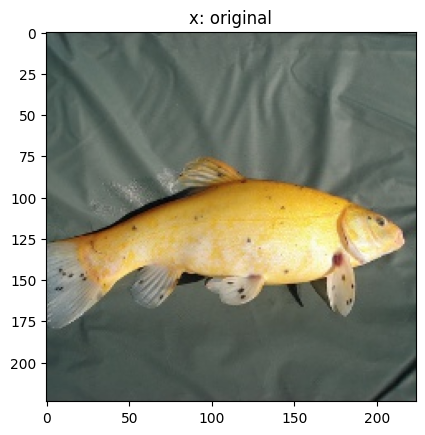

x.shape: torch.Size([1, 3, 224, 224])

y1.shape: torch.Size([1, 1000])
y1 prediction class: 398

y2.shape: torch.Size([1, 3, 224, 224])


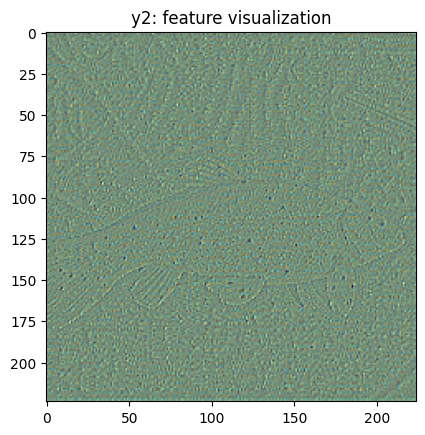

In [12]:
def deconvnet_test():
    # x = torch.randn((5, 3, 224, 224))
    
    x = np.uint8(np.round(load_rgb('./trench.jpeg')))
    plot_rgb(x, title='x: original')
    
    x = np.expand_dims(x, axis=0)
    x = torch.tensor(x.copy()).float()
    x = torch.permute(x, (0, 3, 1, 2))
    
    print('x.shape:', x.shape)
    print()
    
    conv = ConvNet(in_channels = 3, out_channels = 1000, pre_train=True)
    conv.eval()
    
    with torch.no_grad():
        y1 = conv(x)
    
    print('y1.shape:', y1.shape)
    print(f'y1 prediction class: {torch.argmax(y1)}')
    print()
    
    
    deconv = DeConvNet(conv)
    deconv.eval()
    
    with torch.no_grad():
        y2 = deconv(layer_no = 5)
    
    print(f'y2.shape: {y2.shape}')
    
    x2 = torch.permute(y2, (0, 2, 3, 1))
    x2 = torch.squeeze(x2, dim=0).detach().cpu().numpy()
    plot_rgb(x2, title='y2: feature visualization')
    
    # print(f'y2:{y2}')
    # print()

deconvnet_test()

## Training

- ImageNet: resize smallest dimenstion to $256$, crop center region as $256 \times 256$
- Subtracting the per-pixel mean
- Then using $10$ different sub-crops of size $224 \times 224$ (corners + center with(out) horizontal flips)
- Multiple different crops and flips of each training sample to boost training set size

**Stochastic Gradient Descent**
- Mini-batch size = $128$
- Learning Rate = $10^{-2}$
- Momentum = $0.9$
- Epochs = $70$

Visualization of $1_{st}$ layer during training reveals that a few of them dominate (Fig. 6(a)). To combat this:
- Normalize each filter in the covolution layer whose $RMS$ value exceeds a fixed radius of $10^{-1}$ to this fixed radius
- This is curcial, especially in the $1_{st}$ layer of the model, where the input images are roughly in the range $[-128, 128]$.

In [13]:
# code here